### **Imports**

In [1]:
%tensorflow_version

Currently selected TF version: 2.x
Available versions:
* 1.x
* 2.x


In [2]:
pip install tensorflow==2.0

In [3]:
pip install keras==2.3.1

In [4]:
import keras
print(keras.__version__)

Using TensorFlow backend.


2.3.1


In [5]:
import keras
import keras.backend as K
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Dense, Input, LeakyReLU, Dropout
from keras import layers
from keras import optimizers, activations, regularizers, initializers
from keras.regularizers import L1L2
from keras.models import Model, Sequential
from keras.layers.recurrent import LSTM, GRU

from sklearn import metrics
from scipy import stats
import tensorflow as tf
import tensorflow.keras

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, EarlyStopping

import os


## **Setup seed**

In [6]:
seed = 8000

np.random.seed(seed)
np.random.RandomState(seed)
tf.random.set_seed(seed)

# **Parameters of DNN**

In [7]:
n_feature = 2500   #37130 
[n_in, n_hidden1, n_hidden2, n_hidden3, n_output] = [n_feature, 128, 64, 0, 1] 

corruption_level = 0  # 0.3

n_epochs = 1000
batch_size = 32
k_folds = 5

timesteps = 1

#Regularizer Parameters
l1 = 0
l2 = 0

# **Data**

## **Load Data**

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
X = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data/sub-000_feature.csv', header=None)
Y = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data/aro_score.csv', header=None)


In [10]:
X = X.to_numpy() 
Y = Y.to_numpy() 

Y = Y.ravel()

In [11]:
Y = Y.reshape(90, 1)
Y.shape

(90, 1)

In [12]:
X.min()

-10.857999999999999

## **Scale**

In [13]:
from sklearn.preprocessing import MinMaxScaler, normalize, StandardScaler

X = MinMaxScaler().fit_transform(X)
#X = normalize(X, norm='l2')

Y = Y / 10.0

## **Denoising**

In [14]:
def get_corrupted_input(input, corruption_level):
  cr = K.random_binomial(shape= input.shape, p= 1-corruption_level, seed=123) * input
  
  return cr


X = get_corrupted_input(X, corruption_level).numpy()


## **Decomposition**

In [15]:
from sklearn.decomposition import PCA, LatentDirichletAllocation
'''

pca = PCA(n_components = n_feature, svd_solver='full')   # 84, 0.08
#lda = LatentDirichletAllocation(n_components = 90, random_state=0)
pca.fit(X)

X = pca.transform(X)
'''

"\n\npca = PCA(n_components = n_feature, svd_solver='full')   # 84, 0.08\n#lda = LatentDirichletAllocation(n_components = 90, random_state=0)\npca.fit(X)\n\nX = pca.transform(X)\n"

## **Feature Selection**

In [16]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, RFE, SelectFdr, mutual_info_regression
from sklearn import random_projection



#X_new = SelectFdr(chi2, alpha=0.01).fit_transform(X, y)

def select_features(X, y, n_featues):


  fs = SelectKBest(score_func=f_regression, k= n_featues)


  #fs = random_projection.SparseRandomProjection()  # 3856


  fs.fit(X, y)
  X = fs.transform(X)

  return X


In [17]:
X = select_features(X, Y, n_feature)

X.shape

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


(90, 2500)

# **PFA**

In [18]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import defaultdict
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import StandardScaler

class PFA(object):
    def __init__(self, n_features, q=None):
        self.q = q
        self.n_features = n_features

    def fit(self, X):
        if not self.q:
            self.q = X.shape[1]

        sc = StandardScaler()
        X = sc.fit_transform(X)

        pca = PCA(n_components=self.q).fit(X)
        A_q = pca.components_.T

        kmeans = KMeans(n_clusters=self.n_features).fit(A_q)
        clusters = kmeans.predict(A_q)
        cluster_centers = kmeans.cluster_centers_

        dists = defaultdict(list)
        for i, c in enumerate(clusters):
            dist = euclidean_distances([A_q[i, :]], [cluster_centers[c, :]])[0][0]
            dists[c].append((i, dist))

        self.indices_ = [sorted(f, key=lambda x: x[1])[0][0] for f in dists.values()]
        self.features_ = X[:, self.indices_]

In [19]:
'''
pfa = PFA(n_features= n_feature)
pfa.fit(X)

# To get the transformed matrix
X = pfa.features_

# To get the column indices of the kept features
column_indices = pfa.indices_

'''

def gs(X):
    Q, R = np.linalg.qr(X)
    return Q


In [20]:
X.shape, Y.shape

((90, 2500), (90, 1))

In [21]:
X.min()

0.0

# **Custom Metrics**

In [22]:
import keras.backend as K

def mean_pred(y_true, y_pred):
  return K.mean(y_pred)


def STD_pred(y_true, y_pred):
  return K.std(y_pred)

def rmse(y_true, y_pred):
	return K.sqrt(K.mean(K.square(y_pred - y_true), axis= -1))
 

def CC(y_true, y_pred):
  fsp = y_pred - K.mean(y_pred) 
  fst = y_true - K.mean(y_true)

  devP = K.std(y_pred)
  devT = K.std(y_true)

  return K.mean(fsp * fst) / (devP * devT)


# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    #return 1 - ( 1 - SS_res/(SS_tot + K.epsilon()))
    return 1 -  SS_res / SS_tot 
 

# **Callbacks**

In [23]:
class prediction_history(keras.callbacks.Callback):
    def __init__(self):
        self.pred_train = []
        self.pred_test  = []
        self.epochs_ = 0
        self.CC_thresh = 1
        self.CC_test_mean = []

    def rmse(self, y_test, y_pred):
      return np.sqrt(np.mean(np.square(y_pred - y_test), axis= -1))


    def r_square(self, y_test, y_pred):
        SS_res =  np.sum(np.square(y_test - y_pred)) 
        SS_tot = np.sum(np.square(y_test - np.mean(y_test))) 
        #return 1 - ( 1 - SS_res/(SS_tot + K.epsilon()))
        return 1 -  SS_res / SS_tot 



    def CC(self, y_test, y_pred):
        fsp = y_pred - np.mean(y_pred) 
        fst = y_test - np.mean(y_test)
        devP = np.std(y_pred)
        devT = np.std(y_test)
        return np.mean(fsp * fst) / (devP * devT)

    def on_epoch_end(self, epoch, logs={}):
        self.epochs_ = self.epochs_ + 1
        prediction_train = model.predict(x_tr)
        prediction_test = model.predict(x_val)
        self.pred_train.append(prediction_train)
        self.pred_test.append(prediction_test)


        R2_train = self.r_square(y_tr, prediction_train)
        R2_test  = self.r_square(y_val, prediction_test)


        CC_train = self.CC(y_tr, prediction_train)
        CC_test  = self.CC(y_val, prediction_test)
        rmse_test = np.sqrt(metrics.mean_squared_error(y_val, prediction_test))

        self.CC_test_mean.append(CC_test)

        print(self.epochs_ , CC_train, CC_test, rmse_test)

  
        if (self.epochs_ > 200 and CC_train > 0.98 and CC_test > 0.91 and rmse_test < 0.10):
          #self.model.stop_training = True
          print("STOP!")

# **DNN**

## **Create & Compile Model**

In [24]:
def create_model():

  model = Sequential()


  model.add(LSTM(units= n_hidden1, 
                dropout= 0.2,   # 0.5
                recurrent_dropout= 0.5,
                activation = 'relu',
                #recurrent_activation = 'sigmoid',
                
                bias_regularizer = L1L2(l1= l1, l2= l2),
                kernel_regularizer = L1L2(l1= l1, l2= l2),
                activity_regularizer = L1L2(l1= l1, l2= l2),

                kernel_initializer = initializers.he_uniform(),
                return_sequences= True,
                input_shape=(timesteps, n_in)))  


  #model.add(Dropout(0.2))

  model.add(LSTM(units= n_hidden2, 
                dropout= 0.2,   # 0.2
                recurrent_dropout= 0.5,
                activation = 'sigmoid',
                #recurrent_activation = 'sigmoid',

                bias_regularizer = L1L2(l1= l1, l2= l2),
                kernel_regularizer = L1L2(l1= l1, l2= l2),
                activity_regularizer = L1L2(l1= l1, l2= l2),
                 
                #kernel_initializer = initializers.he_uniform(),
                kernel_initializer = initializers.orthogonal(),
                return_sequences= False))



  model.add(Dense(units= n_output, 
                  activation= 'linear'))




  # RMSprop(learning_rate= 0.0001, rho = 0.9)     0.25 (+/-) 0.07
  # Adam(learning_rate= 0.001)     0.27 (+/-) 0.24
  # adamax(learning_rate= 0.001)   0.22 (+/-) 0.14
  # SGD(learning_rate= 0.1, decay= 0.0001, momentum= 0.9)
  # adagrad(learning_rate= 0.01)  


  model.compile(optimizer= optimizers.Adam(learning_rate= 0.0001), 
                loss= keras.losses.mean_squared_error,
                metrics= ['mse', 'mae', 'mape', rmse, CC, r_square, mean_pred, STD_pred])
  


  return model


model = create_model()
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 128)            1346048   
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,395,521
Trainable params: 1,395,521
Non-trainable params: 0
_________________________________________________________________


## **Train model with K-fold CV**

In [25]:
CV_history = [] 

val_data_x = []
val_data_y = []

train_data_x = []
train_data_y = []

pred_val_tr = []
pred_val_ts = []


MSEs  = []
MAEs  = []
MAPEs = []
RMSEs = []
CCs   = []

checkpoint_filepath = '/tmp/checkpoint'

fold_no = 0 

for train_index, val_index in KFold(n_splits= k_folds, shuffle= True, random_state= seed).split(X, Y):

  x_tr, x_val = X[train_index], X[val_index]
  y_tr, y_val = Y[train_index], Y[val_index]

  fold_no += 1

  print('-------------------------------------------------------------------------------')
  print('Training for fold ', fold_no)
  print('-------------------------------------------------------------------------------')


  train_data_x.append(X[train_index])
  train_data_y.append(Y[train_index])
  val_data_x.append(X[val_index])
  val_data_y.append(Y[val_index])

  x_tr  = np.reshape(x_tr , (x_tr.shape[0] , 1, x_tr.shape[1] ))
  x_val = np.reshape(x_val, (x_val.shape[0], 1, x_val.shape[1])) 

  model = None
  model = create_model()

  model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
      filepath=checkpoint_filepath,
      save_weights_only=True,
      monitor='val_CC',
      verbose= 1,
      mode='max',
      save_best_only=True)

  cbk = prediction_history()


  results = model.fit(x_tr, y_tr, epochs= n_epochs,
                          batch_size= batch_size,
                          callbacks = [cbk],
                          verbose = False,
                          validation_data = [x_val, y_val]
                        )

  #Updating to use the best model
  #model.load_weights(checkpoint_filepath)


  pred_val_tr.append(model.predict(x_tr))
  pred_val_ts.append(model.predict(x_val))


  scores = model.evaluate(x_val, y_val)
  print("%s: %.2f" % (model.metrics_names[1], scores[1] ))   #MSE
  MSEs.append(scores[1])
  print("%s: %.2f" % (model.metrics_names[2], scores[2] ))   #MAE
  MAEs.append(scores[2])
  print("%s: %.2f" % (model.metrics_names[3], scores[3] ))   #MAPE
  MAPEs.append(scores[3])
  print("%s: %.2f" % (model.metrics_names[4], scores[4] ))   #RMSE
  RMSEs.append(scores[4])
  print("%s: %.2f" % (model.metrics_names[5], scores[5] ))   #CC
  CCs.append(scores[5])


  CV_history.append(results)
  print("======="*12, end="\n\n\n")



Streaming output truncated to the last 5000 lines.
58 0.8149495674317382 0.7555738210546856 0.09267830084922088
59 0.817892199920227 0.7557373300915681 0.09238760214917965
60 0.8207040672024432 0.7583509678142649 0.09195417284244273
61 0.8236139265581685 0.7609875884568903 0.09258691523976505
62 0.8258865175357231 0.7626262803761883 0.09710926077044417
63 0.8289612456582588 0.7644406725006365 0.09861963981774194
64 0.8341115299172925 0.7660621145625912 0.09328754800653516
65 0.8380012323868717 0.7663980776505881 0.08971545176307016
66 0.8412934619217896 0.770185211769557 0.08883449116213929
67 0.8438807554689547 0.7739157098003804 0.0891480109272541
68 0.8472146113640747 0.7748174486498604 0.08837453628385433
69 0.8496258508033295 0.7766883590762674 0.08961152087399957
70 0.852558637286383 0.7775541315547626 0.08826777347832064
71 0.8562076958354272 0.7794083431964058 0.08744318865634346
72 0.8597629546288076 0.7814862092517455 0.08725633627906881
73 0.862143449432639 0.783147839042428

# **Evaluate**

## **Evaluate Model**

In [26]:
# == Provide average scores ==
print('-----------------------------' * 4)
print('Results per fold: ')
for i in range(0, len(CCs)):
  print('-----------------------------' * 4)
  print(f'Fold {i+1} - MSE: {MSEs[i]} - MAE: {MAEs[i]} - MAPE: {MAPEs[i]} - CC: {CCs[i]}')
print('-----------------------------' * 4)
print('Average scores for all folds:')

print("\nMSE:  %.3f (+/-) %.2f" % (np.mean(MSEs) , np.std(MSEs) ))
print("\nMAE:  %.3f (+/-) %.3f" % (np.mean(MAEs) , np.std(MAEs) ))
print("\nRMSE: %.2f (+/-) %.2f" % (np.mean(RMSEs), np.std(RMSEs)))
print("\nMAPE: %.2f (+/-) %.2f" % (np.mean(MAPEs), np.std(MAPEs)))
print("\nCC:   %.2f (+/-) %.2f" % (np.mean(CCs)  , np.std(CCs)  ))


tr_cc = np.mean((
        CV_history[0].history['CC'][-1],
        CV_history[1].history['CC'][-1],
        CV_history[2].history['CC'][-1],
        CV_history[3].history['CC'][-1],
        CV_history[4].history['CC'][-1]))

print('----------------------------' * 4)

print("\nTrain CC:   %.2f (+/-) %.2f" % (np.mean(tr_cc)  , np.std(tr_cc)  ))

--------------------------------------------------------------------------------------------------------------------
Results per fold: 
--------------------------------------------------------------------------------------------------------------------
Fold 1 - MSE: 0.006247327663004398 - MAE: 0.06463362276554108 - MAPE: 17.073322296142578 - CC: 0.8238074779510498
--------------------------------------------------------------------------------------------------------------------
Fold 2 - MSE: 0.005217407830059528 - MAE: 0.05492926388978958 - MAPE: 12.134449005126953 - CC: 0.7840598225593567
--------------------------------------------------------------------------------------------------------------------
Fold 3 - MSE: 0.013729398138821125 - MAE: 0.10190409421920776 - MAPE: 25.40991973876953 - CC: 0.7629808783531189
--------------------------------------------------------------------------------------------------------------------
Fold 4 - MSE: 0.006655313074588776 - MAE: 0.06176213547

In [27]:
print(CCs)

[0.8238074779510498, 0.7840598225593567, 0.7629808783531189, 0.8652915954589844, 0.8695051074028015]


# **Plots**

## **MSE of Folds**

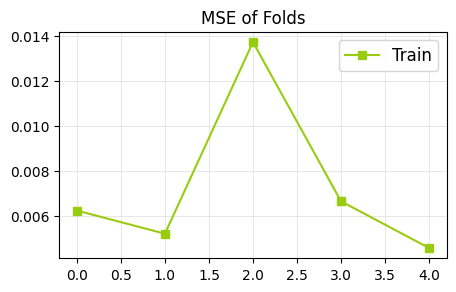

In [28]:
plt.figure(figsize=(5, 3), dpi=100)
ax = plt.plot(MSEs, label='Train', marker='s', color='#99cc11')


plt.title('MSE of Folds')
xtickslocs = np.arange(1, 5, step=1)
plt.legend(loc='best', fontsize='large')
plt.grid(color='#ddd', ls = '-', lw = 0.5)
plt.show()

## **MAE of Folds**

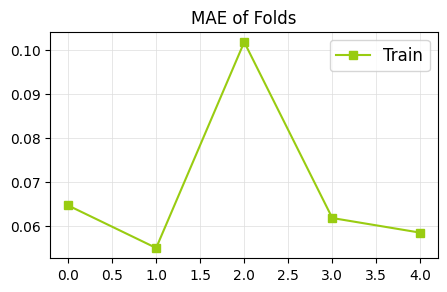

In [29]:
plt.figure(figsize=(5, 3), dpi=100)
ax = plt.plot(MAEs, label='Train', marker='s', color='#99cc11')


plt.title('MAE of Folds')
xtickslocs = np.arange(1, 5, step=1)
plt.legend(loc='best', fontsize='large')
plt.grid(color='#ddd', ls = '-', lw = 0.5)
plt.show()

## **CC of Folds**

In [30]:
train_cc = ( (CV_history[0].history['CC'][499],
         CV_history[1].history['CC'][499],
         CV_history[2].history['CC'][499],
         CV_history[3].history['CC'][499],
         CV_history[4].history['CC'][499]))
train_cc

(0.94903666, 0.93379265, 0.9498115, 0.9284611, 0.96034414)

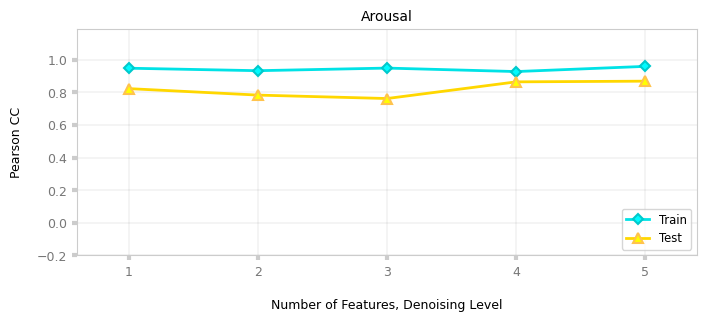

In [31]:
x = [0, 1, 2, 3, 4]
labels = [1, 2, 3, 4, 5]

fig, ax = plt.subplots(figsize=(8, 3), dpi=100)

plt.plot(train_cc, label='Train', color='#00e2e6', linewidth=2, marker='D', markersize = 5,
          MarkerFaceColor='#00fbff', MarkerEdgeColor='#00c9cc', markeredgewidth=1.5)

plt.plot(CCs, label='Test', color='#FFD700', marker='^', linewidth=2, markersize = 7,
         MarkerFaceColor='yellow', MarkerEdgeColor='#ffc34d', markeredgewidth = 1.5)


plt.title('Arousal', fontsize='10')
plt.xlabel('Number of Features, Denoising Level', fontsize='9', color='#000', labelpad=15)
plt.ylabel('Pearson CC', fontsize='9', color='#000', labelpad=10)
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.ylim(-0.2, 1.19)

plt.legend(loc='lower right', fontsize='small')
ax.grid(color='grey', linestyle='-', linewidth=0.2, alpha=0.6)
#ax.xaxis.grid(False)

#removing top and right borders
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)


for ax, color in zip([ax], ['#ccc']):
    plt.setp(ax.spines.values(), color=color)
    plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=color)

ax.tick_params(labelcolor='#777', labelsize='9', width=3)
ax.margins(x=0.1, y=-0.05) 


plt.show()

## **Loss**

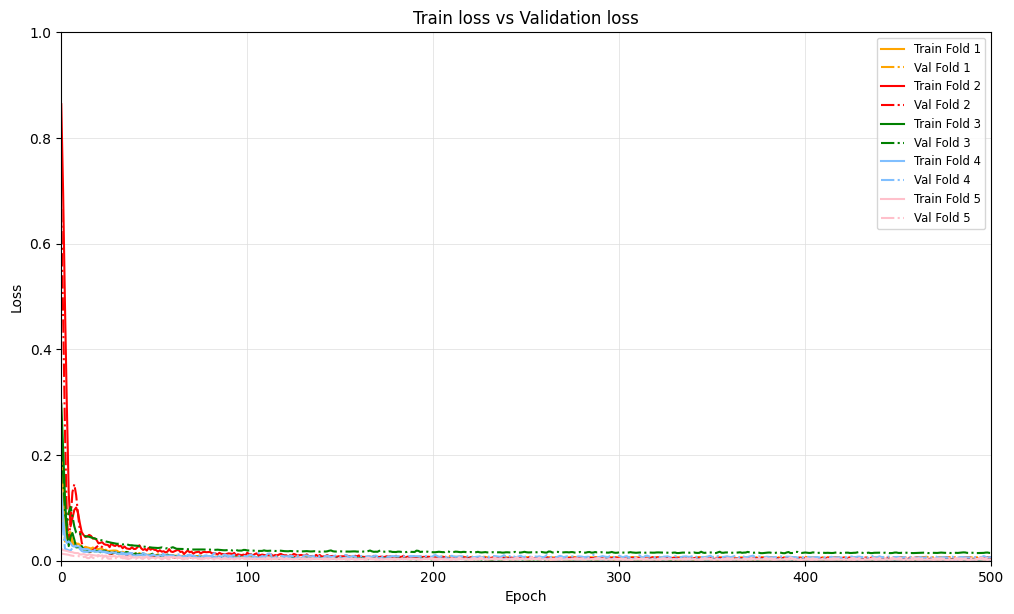

In [32]:
plt.figure(figsize=(12, 7), dpi=100)
plt.title('Train loss vs Validation loss')

plt.plot(CV_history[0].history['loss'], label='Train Fold 1', color='orange')
plt.plot(CV_history[0].history['val_loss'], label='Val Fold 1', color='orange', linestyle = "dashdot")

plt.plot(CV_history[1].history['loss'], label='Train Fold 2', color='red', )
plt.plot(CV_history[1].history['val_loss'], label='Val Fold 2', color='red', linestyle = "dashdot")

plt.plot(CV_history[2].history['loss'], label='Train Fold 3', color='green', )
plt.plot(CV_history[2].history['val_loss'], label='Val Fold 3', color='green', linestyle = "dashdot")

plt.plot(CV_history[3].history['loss'], label='Train Fold 4', color='#80bfff', )
plt.plot(CV_history[3].history['val_loss'], label='Val Fold 4', color='#80bfff', linestyle = "dashdot")

plt.plot(CV_history[4].history['loss'], label='Train Fold 5', color='#FFC0CB', )
plt.plot(CV_history[4].history['val_loss'], label='Val Fold 5', color='#FFC0CB', linestyle = "dashdot")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xlim(0, 500)
plt.ylim(0, 1)
plt.legend(loc='best', fontsize='small')
plt.grid(color='#ddd', ls = '-', lw = 0.5)
plt.show()

## **MAE**

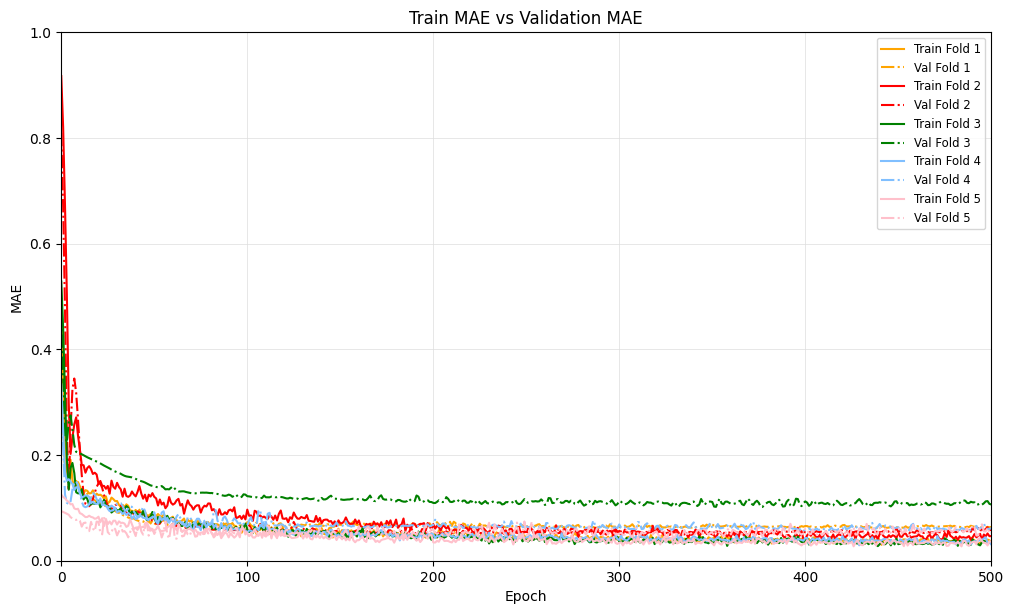

In [33]:
plt.figure(figsize=(12, 7), dpi=100)
plt.title('Train MAE vs Validation MAE')

plt.plot(CV_history[0].history['mae'], label='Train Fold 1', color='orange')
plt.plot(CV_history[0].history['val_mae'], label='Val Fold 1', color='orange', linestyle = "dashdot")

plt.plot(CV_history[1].history['mae'], label='Train Fold 2', color='red', )
plt.plot(CV_history[1].history['val_mae'], label='Val Fold 2', color='red', linestyle = "dashdot")

plt.plot(CV_history[2].history['mae'], label='Train Fold 3', color='green', )
plt.plot(CV_history[2].history['val_mae'], label='Val Fold 3', color='green', linestyle = "dashdot")

plt.plot(CV_history[3].history['mae'], label='Train Fold 4', color='#80bfff', )
plt.plot(CV_history[3].history['val_mae'], label='Val Fold 4', color='#80bfff', linestyle = "dashdot")

plt.plot(CV_history[4].history['mae'], label='Train Fold 5', color='#FFC0CB', )
plt.plot(CV_history[4].history['val_mae'], label='Val Fold 5', color='#FFC0CB', linestyle = "dashdot")

plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.xlim(0, 500)
plt.ylim(0, 1)
plt.legend(loc='best', fontsize='small')
plt.grid(color='#ddd', ls = '-', lw = 0.5)
plt.show()

## **CC**

0.94903666 ,  0.82300865650177
0.93379265 ,  0.7461107969284058
0.9498115 ,  0.7475636005401611
0.9284611 ,  0.8652217388153076
0.96034414 ,  0.8753465414047241


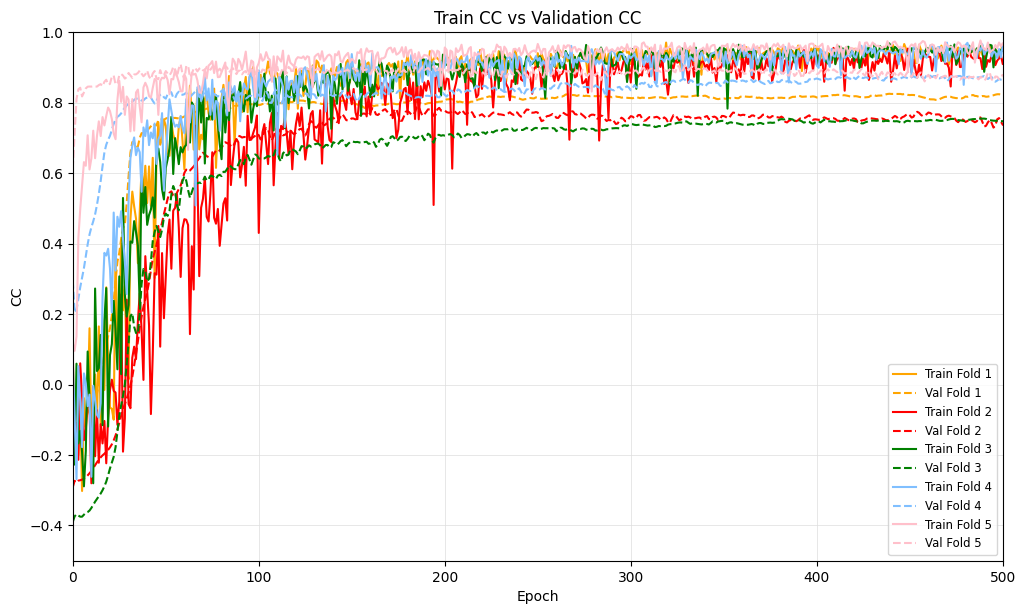

In [34]:
plt.figure(figsize=(12, 7), dpi=100)
plt.title('Train CC vs Validation CC')

plt.plot(CV_history[0].history['CC'], label='Train Fold 1', color='orange', linestyle = "-")
plt.plot(CV_history[0].history['val_CC'], label='Val Fold 1', color='orange' , linestyle = "dashed")

plt.plot(CV_history[1].history['CC'], label='Train Fold 2', color='red', linestyle = "-")
plt.plot(CV_history[1].history['val_CC'], label='Val Fold 2', color='red' , linestyle = "dashed")

plt.plot(CV_history[2].history['CC'], label='Train Fold 3', color='green',  linestyle = "-")
plt.plot(CV_history[2].history['val_CC'], label='Val Fold 3', color='green' , linestyle = "dashed")

plt.plot(CV_history[3].history['CC'], label='Train Fold 4', color='#80bfff')
plt.plot(CV_history[3].history['val_CC'], label='Val Fold 4', color='#80bfff' , linestyle = "dashed")


plt.plot(CV_history[4].history['CC'], label='Train Fold 5', color='#FFC0CB')
plt.plot(CV_history[4].history['val_CC'], label='Val Fold 5', color='#FFC0CB', linestyle = "dashed")

plt.xlabel('Epoch')
plt.ylabel('CC')
plt.xlim(0, 500)
plt.ylim(-0.5, 1)
plt.legend(loc='best', fontsize='small')
plt.grid(color='#ddd', ls = '-', lw = 0.5)

print(CV_history[0].history['CC'][499], ', ' , CV_history[0].history['val_CC'][499])
print(CV_history[1].history['CC'][499], ', ' , CV_history[1].history['val_CC'][499])
print(CV_history[2].history['CC'][499], ', ' , CV_history[2].history['val_CC'][499])
print(CV_history[3].history['CC'][499], ', ' , CV_history[3].history['val_CC'][499])
print(CV_history[4].history['CC'][499], ', ' , CV_history[4].history['val_CC'][499])


plt.show()


# **Predict Pattern**

Patterns of Estimated Emotion Response from **Training Data**


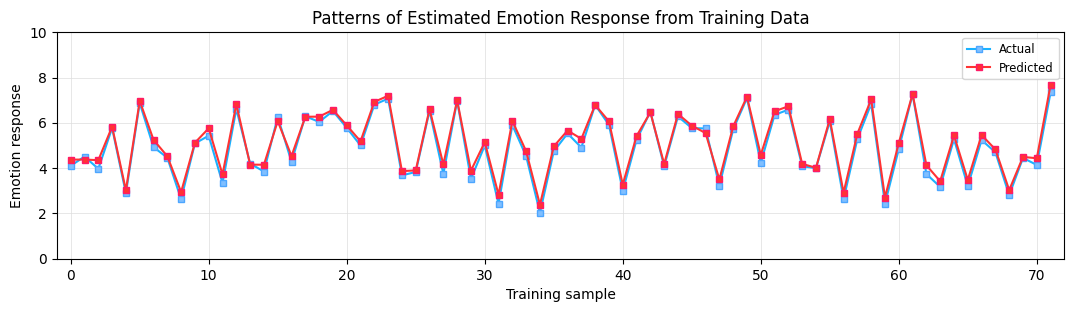

In [35]:
plt.figure(figsize=(13, 3), dpi=100)
plt.plot(train_data_y[0]*10, label='Actual', marker='s', color='#1ab2ff', MarkerEdgeColor='#4da6ff',MarkerFaceColor='#80bfff', markersize=5)
plt.plot(pred_val_tr[0]*10, label='Predicted', marker='s', color='#ff3333', MarkerEdgeColor='#ff1a66',MarkerFaceColor='#ff3333', markersize=5)

plt.xlim(-1, y_tr.shape[0])
plt.ylim([0, 10])
plt.title('Patterns of Estimated Emotion Response from Training Data')
plt.xlabel('Training sample')
plt.ylabel('Emotion response')
plt.legend(loc='best', fontsize='small')
plt.grid(color='#ddd', ls = '-', lw = 0.5)
plt.show()

Patterns of Estimated Emotion Response from **Test Data**

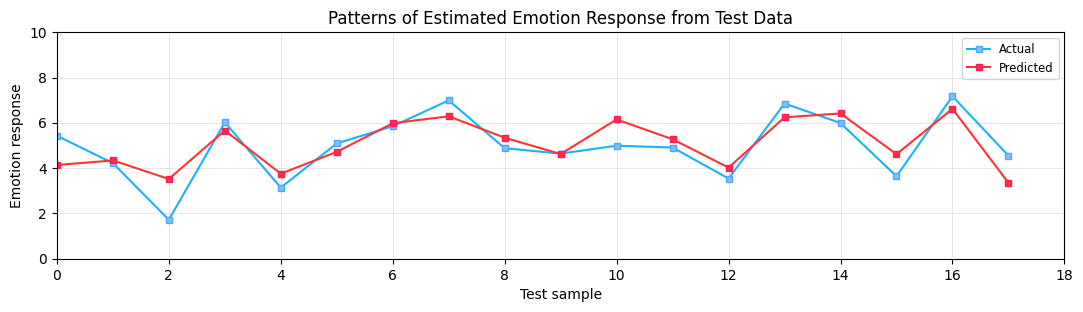

In [36]:
plt.figure(figsize=(13, 3), dpi=100)

plt.plot(val_data_y[0]*10, label='Actual', marker='s', color='#1ab2ff', MarkerEdgeColor='#4da6ff',MarkerFaceColor='#80bfff', markersize=5)
plt.plot(pred_val_ts[0]*10, label='Predicted', marker='s', color='#ff3333', MarkerEdgeColor='#ff1a66',MarkerFaceColor='#ff3333', markersize=5)
plt.ylim([0, 10])
plt.xlim([0, 18])

plt.title('Patterns of Estimated Emotion Response from Test Data')
plt.xlabel('Test sample')
plt.ylabel('Emotion response')
plt.legend(loc='best', fontsize='small')
plt.grid(color='#ddd', ls = '-', lw = 0.5)
plt.show()

### **Predict Pattern for all Folds**

In [37]:
YTr = np.vstack([train_data_y[0], train_data_y[1], train_data_y[2], train_data_y[3], train_data_y[4]])

PredTr = np.vstack([pred_val_tr[0], pred_val_tr[1], pred_val_tr[2], pred_val_tr[3], pred_val_tr[4]])

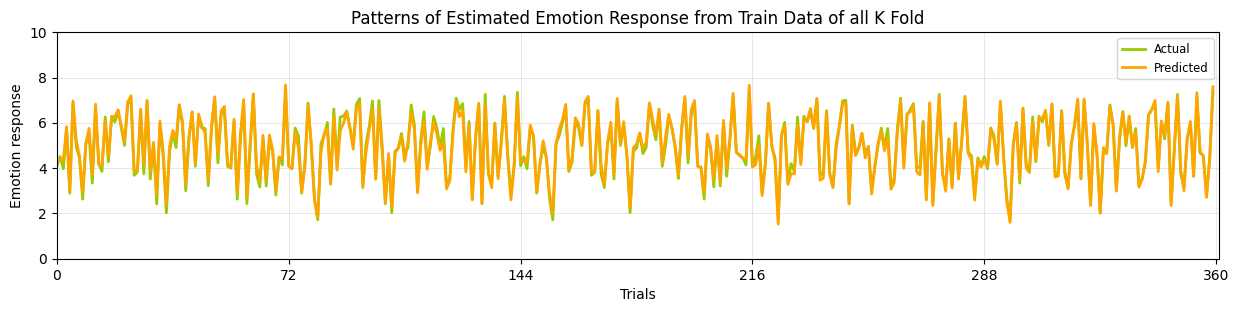

In [38]:
plt.figure(figsize=(15, 3), dpi=100)

plt.plot(YTr*10, label='Actual', color='#9C0', marker='o', MarkerFaceColor='#9C0', markersize=0,lw=2)
plt.plot(PredTr*10, label='Predicted', color='orange', marker='o', MarkerFaceColor='#ff80aa', markersize=0,lw=2)

plt.xlim([0, 361])
plt.ylim([0, 10])
plt.xticks(np.arange(0, 361, 72))
plt.title('Patterns of Estimated Emotion Response from Train Data of all K Fold')
plt.xlabel('Trials')
plt.ylabel('Emotion response')
plt.legend(loc='best', fontsize='small')
plt.grid(color='#ddd', ls = '-', lw = 0.5)
plt.show()

In [39]:
YVal = np.vstack([val_data_y[0], val_data_y[1], val_data_y[2], val_data_y[3], val_data_y[4]])

PredVal = np.vstack([pred_val_ts[0], pred_val_ts[1], pred_val_ts[2], pred_val_ts[3], pred_val_ts[4]])

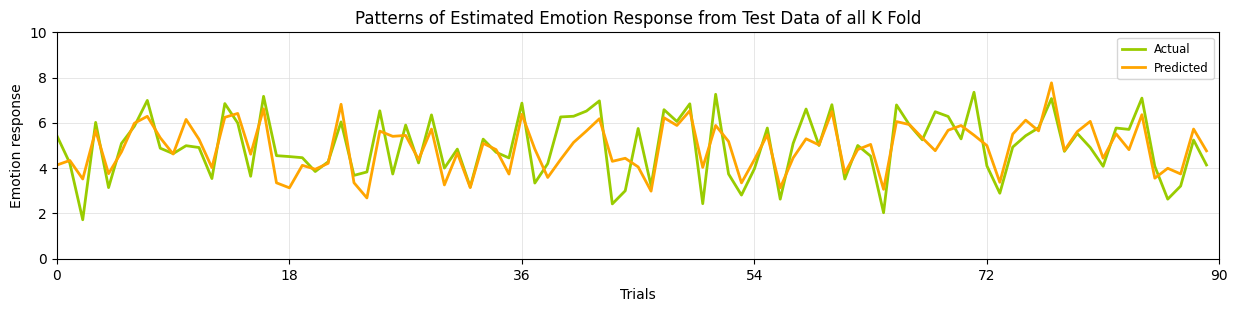

In [40]:
plt.figure(figsize=(15, 3), dpi=100)

plt.plot(YVal*10, label='Actual', color='#9C0', marker='o', MarkerFaceColor='#9C0', markersize=0,lw=2)
plt.plot(PredVal*10, label='Predicted', color='orange', marker='o', MarkerFaceColor='#ff80aa', markersize=0,lw=2)

plt.xlim([0, 90])
plt.ylim([0, 10])
plt.xticks(np.arange(0, 91, 18))
plt.title('Patterns of Estimated Emotion Response from Test Data of all K Fold')
plt.xlabel('Trials')
plt.ylabel('Emotion response')
plt.legend(loc='best', fontsize='small')
plt.grid(color='#ddd', ls = '-', lw = 0.5)
plt.show()

# **SVM**

In [41]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, cross_validate

In [42]:
Y = Y.ravel()

# **Metrics**

In [43]:
# coefficient of determination (R^2) for regression
def r_square(self, y_test, y_pred):
        SS_res = np.sum(np.square(y_test - y_pred)) 
        SS_tot = np.sum(np.square(y_test - np.mean(y_test))) 
        #return 1 - ( 1 - SS_res/(SS_tot + K.epsilon()))
        return 1 -  SS_res / SS_tot


def CC_Pearson(y_test, y_pred, **kwargs):
  fsp = y_pred - np.mean(y_pred) 
  fst = y_test - np.mean(y_test)
  devP = np.std(y_pred)
  devT = np.std(y_test)
  return np.mean(fsp * fst) / (devP * devT)


def rmse(y_test, y_pred, **kwargs):
	return np.sqrt(np.mean(K.square(y_pred - y_test), axis= -1))

# **make_scorer**

In [44]:
# prepare scorers: mean_sqaured_error with option multioutput
scorer = {'mse_score': make_scorer(metrics.mean_squared_error, 
                        greater_is_better = False, 
                        multioutput = 'uniform_average'),
              
              'mae_score': make_scorer(metrics.mean_absolute_error, 
                        greater_is_better = False, 
                        #multioutput = 'uniform_average'
                        )                         
              }

CC_scorer = make_scorer(CC_Pearson, greater_is_better = True)

RMSE_scorer = make_scorer(rmse, greater_is_better = False)

# **Linear SVM**

In [45]:
# Linear ep:0.01, 0.001,...  tol:0.1
model_lin = SVR(kernel='linear', C = 0.01, epsilon = 0.01, tol = 0.1)  # 97, 51


#all feature
model_lin = SVR(kernel='linear', C = 1, epsilon = 0.01, tol = 0.01)  

In [46]:
model_lin = SVR(kernel='linear', C = 0.0001, epsilon = 0.01, tol = 0.0001) 

In [47]:
#n_samples = X.shape[0]
cv = KFold(n_splits= 5, shuffle= True, random_state= seed)

lin_mae = cross_val_score(model_lin, X, Y, cv=cv,  scoring = scorer['mae_score'])
#lin_rmse = cross_val_score(model_lin, X, Y, cv=cv,  scoring = RMSE_scorer)
lin_CC = cross_validate(model_lin, X, Y, cv=cv,  scoring = CC_scorer, return_train_score=True)
lin_Rsqure = cross_val_score(model_lin, X, Y, cv=cv,  scoring = 'r2')

## **cross-validation**

In [48]:
val_data_x2 = []
val_data_y2 = []

train_data_x2 = []
train_data_y2 = []

pred_val_tr2 = []
pred_val_ts2 = []

SVM_CCs2   = []


for train_index, val_index in cv.split(X, Y):

#for train_index, val_index in KFold(n_splits= 5, shuffle= True, random_state= seed).split(X, Y):

  x_tr, x_val = X[train_index], X[val_index]
  y_tr, y_val = Y[train_index], Y[val_index]

  train_data_x2.append(X[train_index])
  train_data_y2.append(Y[train_index])
  val_data_x2.append(X[val_index])
  val_data_y2.append(Y[val_index])

  x_tr  = np.reshape(x_tr , (x_tr.shape[0] , x_tr.shape[1] ))
  x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1])) 

  model_lin.fit(x_tr, y_tr)

  pred_val_tr2.append(model_lin.predict(x_tr))
  pred_val_ts2.append(model_lin.predict(x_val))

  scores = model_lin.score(x_tr, y_tr )
  print("%.2f" % scores)   #CC
  SVM_CCs2.append(scores)

print("\nMean R2: %.2f" % np.mean(SVM_CCs2))  

0.30
0.28
0.30
0.31
0.29

Mean R2: 0.30


## **CC Linear-SVM**

In [49]:
print(lin_CC['train_score'])
print(lin_CC['test_score'])

print("\nTrain CC: %.2f (+/-) %.2f"  % (lin_CC['train_score'].mean(), lin_CC['train_score'].std()))
print("\nTest CC:  %.2f (+/-) %.2f"  % (lin_CC['test_score'].mean(), lin_CC['test_score'].std()))
#print("\nRMSE:  %.2f" % (lin_rmse.mean()))
print("\nMAE:   %.2f" % (lin_mae.mean()*-1))

[0.72700177 0.762236   0.80323439 0.73955395 0.77454982]
[0.65752834 0.75148911 0.70135981 0.69856916 0.79449695]

Train CC: 0.76 (+/-) 0.03

Test CC:  0.72 (+/-) 0.05

MAE:   0.11


## **Linear-SVM Predict Pattern**

### **Train**

In [50]:
YTr2 = np.vstack([train_data_y2[0], train_data_y2[1], train_data_y2[2], train_data_y2[3], train_data_y2[4]])

PredTr2 = np.vstack([pred_val_tr2[0], pred_val_tr2[1], pred_val_tr2[2], pred_val_tr2[3], pred_val_tr2[4]])

In [51]:
YTr2 = YTr2.reshape(360, 1)
PredTr2 = PredTr2.reshape(360, 1)

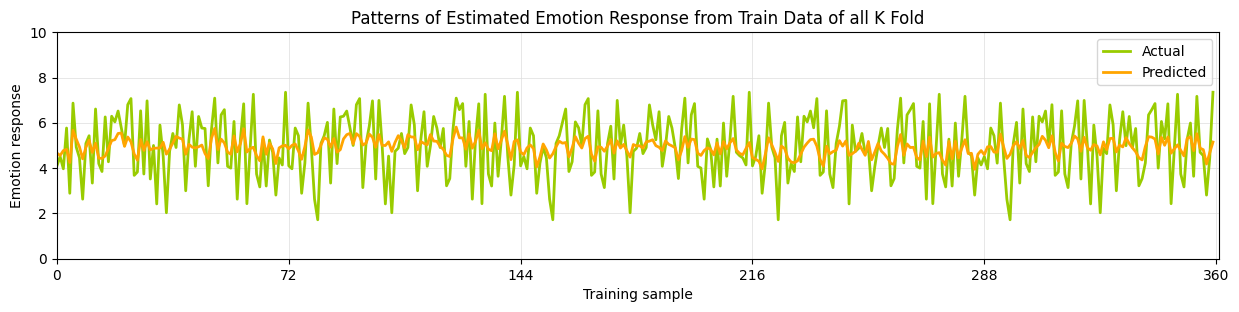

In [52]:
plt.figure(figsize=(15, 3), dpi=100)

plt.plot(YTr2*10, label='Actual', color='#9C0', marker='o', MarkerFaceColor='#9C0', markersize=0,lw=2)
plt.plot(PredTr2*10, label='Predicted', color='orange', marker='o', MarkerFaceColor='#ff80aa', markersize=0,lw=2)

plt.xlim([0, 361])
plt.ylim([0, 10])
plt.xticks(np.arange(0, 361, 72))
plt.title('Patterns of Estimated Emotion Response from Train Data of all K Fold')
plt.xlabel('Training sample')
plt.ylabel('Emotion response')
plt.legend(loc='best', fontsize='medium')
plt.grid(color='#ddd', ls = '-', lw = 0.5)
plt.show()

### **Test**

In [53]:
YVal2 = np.vstack([val_data_y2[0], val_data_y2[1], val_data_y2[2], val_data_y2[3], val_data_y2[4]])

PredVal2 = np.vstack([pred_val_ts2[0], pred_val_ts2[1], pred_val_ts2[2], pred_val_ts2[3], pred_val_ts2[4]])

In [54]:
YVal2 = YVal2.reshape(90, 1)
PredVal2 = PredVal2.reshape(90, 1)

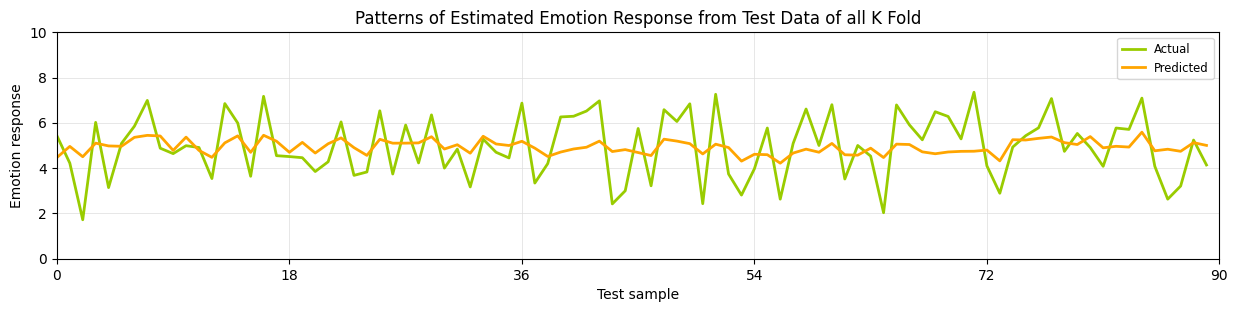

In [55]:
plt.figure(figsize=(15, 3), dpi=100)

plt.plot(YVal2*10, label='Actual', color='#9C0', marker='o', MarkerFaceColor='#9C0', markersize=0,lw=2)
plt.plot(PredVal2*10, label='Predicted', color='orange', marker='o', MarkerFaceColor='#ff80aa', markersize=0,lw=2)

plt.xlim([0, 90])
plt.ylim([0, 10])
plt.xticks(np.arange(0, 91, 18))
plt.title('Patterns of Estimated Emotion Response from Test Data of all K Fold')
plt.xlabel('Test sample')
plt.ylabel('Emotion response')
plt.legend(loc='best', fontsize='small')
plt.grid(color='#ddd', ls = '-', lw = 0.5)
plt.show()

# **RBF SVM**

In [56]:
#RBF # tol=0.01,0.001, 0.0001, ep=0.001, gama=0.001(100,59), 0.0001(94,61) : 0.61+18, 0.94
model_rbf = SVR(kernel = 'rbf', C = 10, epsilon = 0.001, tol=0.01, gamma=0.001)  



# All feature
#RBF
model_rbf = SVR(kernel = 'rbf', C =10, epsilon = 0.00001, tol=0.1, gamma=0.0001)  

In [57]:
model_rbf = SVR(kernel = 'rbf', C =10, epsilon = 0.1, tol=0.1, gamma=0.01) 

In [58]:
#n_samples = X.shape[0]
cv = KFold(n_splits= 5, shuffle= True, random_state= seed)

rbf_mae = cross_val_score(model_rbf, X, Y, cv=cv,  scoring = scorer['mae_score'])
#rbf_rmse = cross_val_score(model_rbf, X, Y, cv=cv,  scoring = RMSE_scorer)
rbf_CC = cross_validate(model_rbf, X, Y, cv=cv,  scoring = CC_scorer, return_train_score=True)
rbf_Rsqure = cross_val_score(model_rbf, X, Y, cv=cv,  scoring = 'r2')

## **cross-validation**

In [59]:
val_data_x3 = []
val_data_y3 = []

train_data_x3 = []
train_data_y3 = []

pred_val_tr3 = []
pred_val_ts3 = []

SVM_CCs3   = []


for train_index, val_index in cv.split(X, Y):

#for train_index, val_index in KFold(n_splits= 5, shuffle= True, random_state= seed).split(X, Y):

  x_tr, x_val = X[train_index], X[val_index]
  y_tr, y_val = Y[train_index], Y[val_index]

  train_data_x3.append(X[train_index])
  train_data_y3.append(Y[train_index])
  val_data_x3.append(X[val_index])
  val_data_y3.append(Y[val_index])

  x_tr  = np.reshape(x_tr , (x_tr.shape[0] , x_tr.shape[1] ))
  x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1])) 

  model_rbf.fit(x_tr, y_tr)

  pred_val_tr3.append(model_rbf.predict(x_tr))
  pred_val_ts3.append(model_rbf.predict(x_val))

  scores = model_rbf.score(x_tr, y_tr )
  print("%.2f" % scores)   #CC
  SVM_CCs3.append(scores)

print("\nMean R2: %.2f" % np.mean(SVM_CCs3))  

0.63
0.67
0.62
0.65
0.59

Mean R2: 0.63


## **CC RBF SVM**

In [60]:
print(rbf_CC['train_score'])
print(rbf_CC['test_score'])

print("\nTrain CC: %.2f (+/-) %.2f"  % (rbf_CC['train_score'].mean(), rbf_CC['train_score'].std()))
print("\nTest CC:  %.2f (+/-) %.2f"  % (rbf_CC['test_score'].mean(), rbf_CC['test_score'].std()))
#print("\nRMSE:  %.2f" % (rbf_rmse.mean()))
print("\nMAE:   %.2f" % (rbf_mae.mean()*-1))

[0.88360094 0.91494295 0.86915009 0.88295583 0.87322423]
[0.80749354 0.68149954 0.64247089 0.70138803 0.71604779]

Train CC: 0.88 (+/-) 0.02

Test CC:  0.71 (+/-) 0.05

MAE:   0.10


## **RBF-SVM Predict Pattern**

### **Train**

In [61]:
YTr3 = np.vstack([train_data_y3[0], train_data_y3[1], train_data_y3[2], train_data_y3[3], train_data_y3[4]])

PredTr3 = np.vstack([pred_val_tr3[0], pred_val_tr3[1], pred_val_tr3[2], pred_val_tr3[3], pred_val_tr3[4]])

In [62]:
YTr3 = YTr3.reshape(360, 1)
PredTr3 = PredTr3.reshape(360, 1)

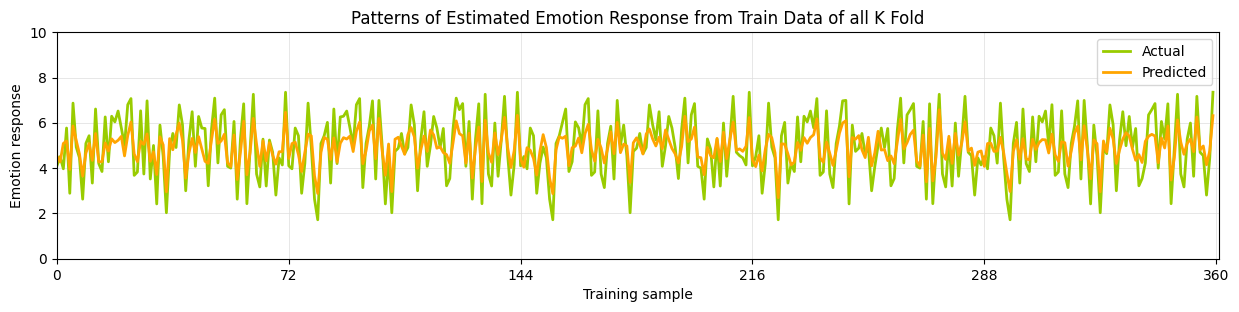

In [63]:
plt.figure(figsize=(15, 3), dpi=100)

plt.plot(YTr3*10, label='Actual', color='#9C0', marker='o', MarkerFaceColor='#9C0', markersize=0,lw=2)
plt.plot(PredTr3*10, label='Predicted', color='orange', marker='o', MarkerFaceColor='#ff80aa', markersize=0,lw=2)

plt.xlim([0, 361])
plt.ylim([0, 10])
plt.xticks(np.arange(0, 361, 72))
plt.title('Patterns of Estimated Emotion Response from Train Data of all K Fold')
plt.xlabel('Training sample')
plt.ylabel('Emotion response')
plt.legend(loc='best', fontsize='medium')
plt.grid(color='#ddd', ls = '-', lw = 0.5)
plt.show()

### **Test**

In [64]:
YVal3 = np.vstack([val_data_y3[0], val_data_y3[1], val_data_y3[2], val_data_y3[3], val_data_y3[4]])

PredVal3 = np.vstack([pred_val_ts3[0], pred_val_ts3[1], pred_val_ts3[2], pred_val_ts3[3], pred_val_ts3[4]])

In [65]:
YVal3 = YVal3.reshape(90, 1)
PredVal3 = PredVal3.reshape(90, 1)

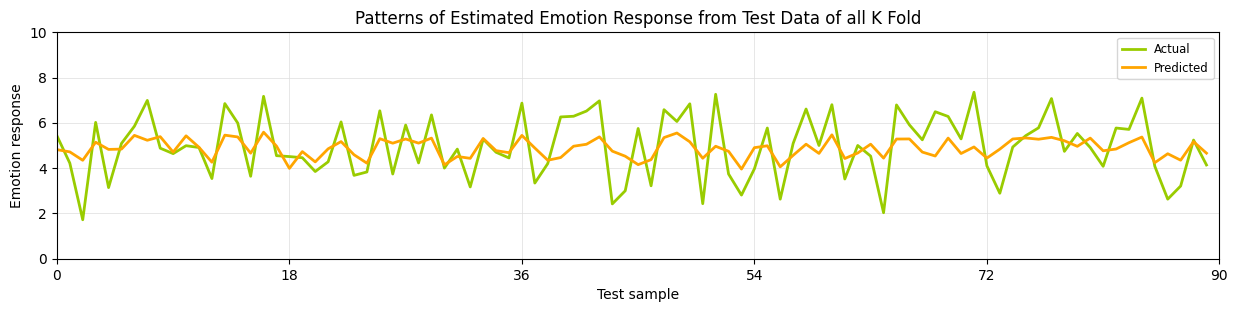

In [66]:
plt.figure(figsize=(15, 3), dpi=100)

plt.plot(YVal3*10, label='Actual', color='#9C0', marker='o', MarkerFaceColor='#9C0', markersize=0,lw=2)
plt.plot(PredVal3*10, label='Predicted', color='orange', marker='o', MarkerFaceColor='#ff80aa', markersize=0,lw=2)

plt.xlim([0, 90])
plt.ylim([0, 10])
plt.xticks(np.arange(0, 91, 18))
plt.title('Patterns of Estimated Emotion Response from Test Data of all K Fold')
plt.xlabel('Test sample')
plt.ylabel('Emotion response')
plt.legend(loc='best', fontsize='small')
plt.grid(color='#ddd', ls = '-', lw = 0.5)
plt.show()

# **LR**

In [67]:
from sklearn import datasets, linear_model

LR = linear_model.LinearRegression()
lr_scores = (cross_val_score(LR, X, Y, cv=cv,  scoring = CC_scorer))
print(lr_scores)

print("\nLR CC:   %.2f (+/-) %.2f" % (lr_scores.mean(), lr_scores.std()))


[0.86262381 0.74824315 0.76258298 0.89180769 0.88768905]

LR CC:   0.83 (+/-) 0.06


# **Box Plot**

<Figure size 7500x2500 with 0 Axes>

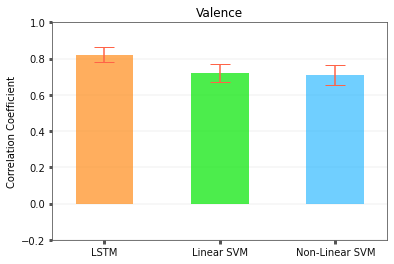

In [68]:
lin_svm = lin_CC['test_score']
nonlin_svm = rbf_CC['test_score']


# Calculate the average
lstm_mean = np.mean(CCs)
lin_svm_mean = np.mean(lin_svm)
nonlin_svm_mean = np.mean(nonlin_svm)

# Calculate the standard deviation
lstm_std = np.std(CCs)
lin_svm_std = np.std(lin_svm)
nonlin_svm_std = np.std(nonlin_svm)

# Create lists for the plot
materials = ['LSTM', 'Linear SVM', 'Non-Linear SVM']
x_pos = np.arange(len(materials))
CTEs = [lstm_mean, lin_svm_mean, nonlin_svm_mean]
error = [lstm_std, lin_svm_std, nonlin_svm_std]


plt.figure(figsize=(15, 5), dpi=500)
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.7, ecolor='tomato', capsize=10,
       color=['#ff8c1a', '#00e600', '#33bbff'], width=0.5, zorder=3)

ax.set_ylabel('Correlation Coefficient')
ax.set_xticks(x_pos)
ax.set_xticklabels(materials, fontsize=2)
ax.set_title('Valence')



ax.grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5, zorder=0)
ax.xaxis.grid(False)
plt.ylim(-0.2, 1)
#plt.yticks(np.arange(-0.2, 1, 0.1))
ax.margins(x=0.08, y=0.0)



for ax, color in zip([ax], ['#555']):
    plt.setp(ax.spines.values(), color=color)
    plt.setp([ax.get_xticklines(), ax.get_yticklines()], color=color)

ax.tick_params(labelcolor='#111', labelsize='medium', width=3)


plt.show()

# **LSTM vs SVM**

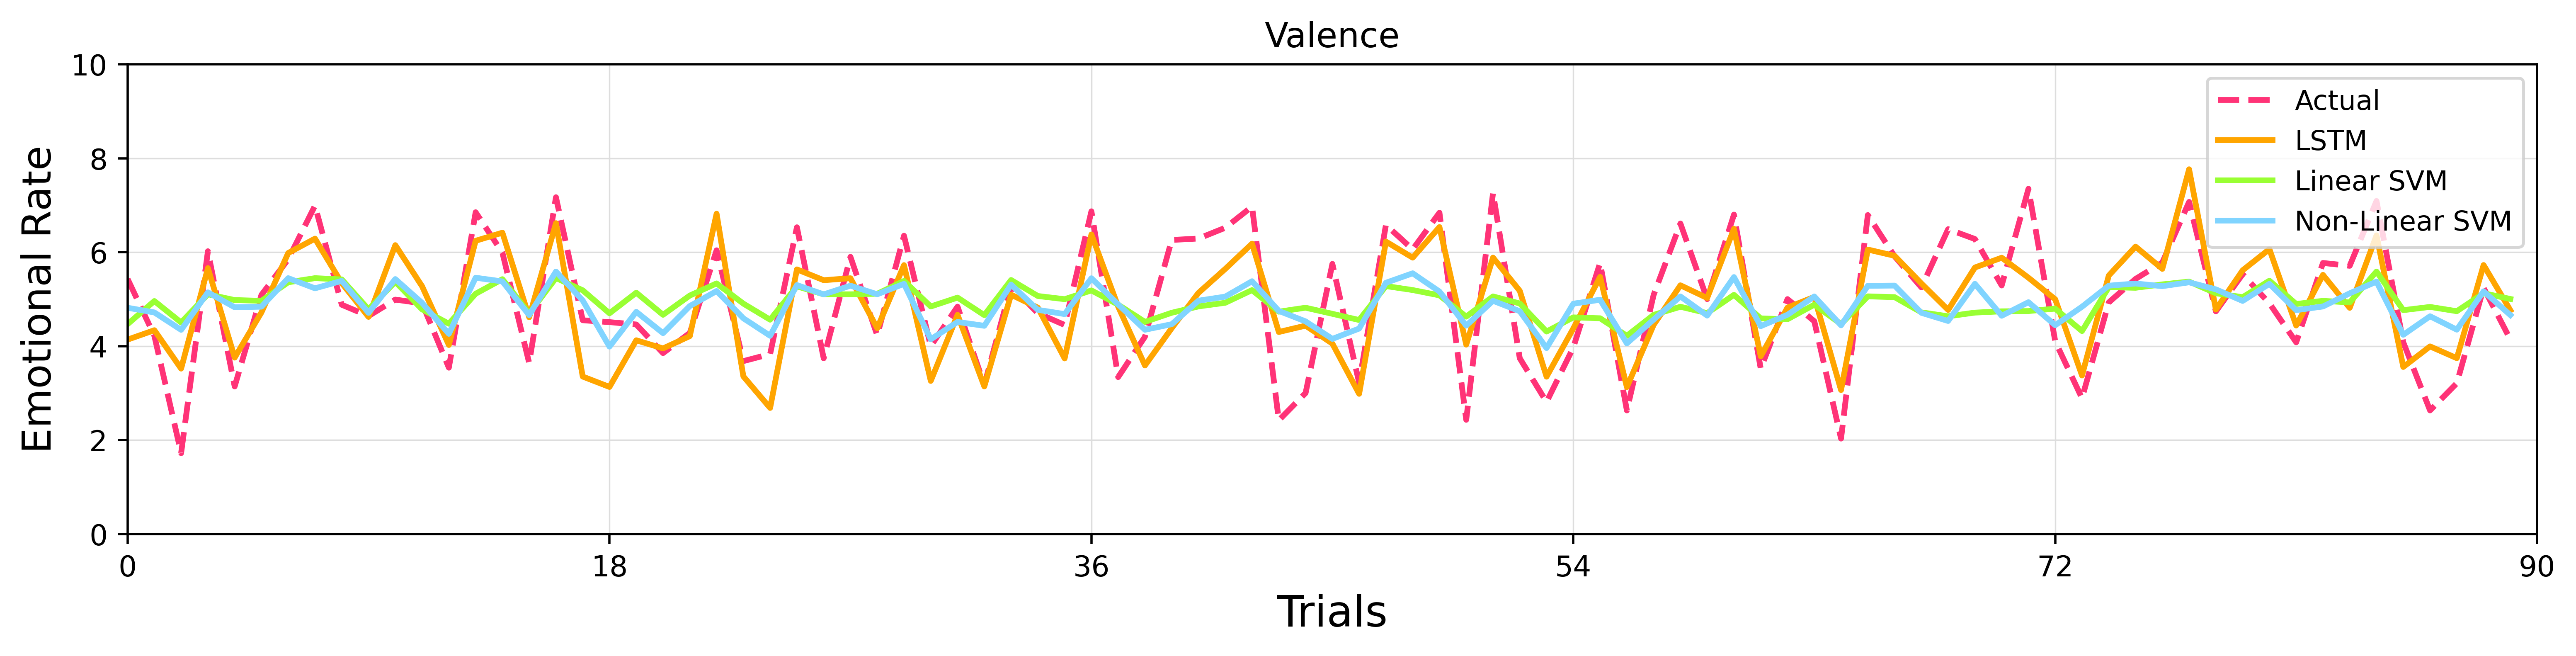

In [69]:
plt.figure(1, figsize=(15, 3), dpi=500)

plt.plot(YVal*10,     label='Actual', color='#ff3377', lw=2, linestyle='--')
plt.plot(PredVal*10,  label='LSTM', color='orange', lw=2)
plt.plot(PredVal2*10, label='Linear SVM', color='#99ff33', lw=2, linestyle='-')
plt.plot(PredVal3*10, label='Non-Linear SVM', color='#80d4ff', lw=2, linestyle='-')

plt.title('Valence')
plt.xlabel('Trials', fontsize=15)
plt.ylabel('Emotional Rate', fontsize=14)
plt.legend(loc='best', fontsize='9.5')
plt.grid(color='#ddd', ls = '-', lw = 0.5)

plt.xlim([0, 90])
plt.ylim([0, 10])
plt.xticks(np.arange(0, 91, 18))

plt.show()